#  **Some Helper Function:**

##Understanding Data

Dataset used:

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv("/content/drive/MyDrive/AI and Machine Learning/Week2/mnist_dataset.csv")
print("Dataset Preview:")
print(df.head())
print("\nDataset Information:")
print(df.info())

Dataset Preview:
   label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0      5        0        0        0        0        0        0        0   
1      0        0        0        0        0        0        0        0   
2      4        0        0        0        0        0        0        0   
3      1        0        0        0        0        0        0        0   
4      9        0        0        0        0        0        0        0   

   pixel_7  pixel_8  ...  pixel_774  pixel_775  pixel_776  pixel_777  \
0        0        0  ...          0          0          0          0   
1        0        0  ...          0          0          0          0   
2        0        0  ...          0          0          0          0   
3        0        0  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  
0          0          0      

In [23]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_one_hot = one_hot_encoder.fit_transform(y_encoded.reshape(-1, 1))

print("\nUnique Classes:", np.unique(y))
print("Encoded Labels:", np.unique(y_encoded))
print("One-Hot Encoded Labels:\n", y_one_hot[:5])


Unique Classes: [0]
Encoded Labels: [0]
One-Hot Encoded Labels:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot)

print("\nShapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (48000, 783) y_train: (48000, 1)
X_test: (12000, 783) y_test: (12000, 1)


## Softmax Function:

In [25]:
import numpy as np

def softmax(z):
    """
    Compute the softmax probabilities for a given input matrix.

    Parameters:
    z (numpy.ndarray): Logits (raw scores) of shape (m, n), where
                       - m is the number of samples.
                       - n is the number of classes.

    Returns:
    numpy.ndarray: Softmax probability matrix of shape (m, n), where
                   each row sums to 1 and represents the probability
                   distribution over classes.

    Notes:
    - The input to softmax is typically computed as: z = XW + b.
    - Uses numerical stabilization by subtracting the max value per row.
    """
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


### Softmax Test Case:

This test case checks that each row in the resulting softmax probabilities sums to 1, which is the fundamental property of softmax.

In [26]:
z_test = np.array([[2.0, 1.0, 0.1], [1.0, 1.0, 1.0]])
softmax_output = softmax(z_test)

row_sums = np.sum(softmax_output, axis=1)

assert np.allclose(row_sums, 1), f"Test failed: Row sums are {row_sums}"

print("Softmax function passed the test case!")

Softmax function passed the test case!


## Prediction Function:

In [27]:
def predict_softmax(X, W, b):
    """
    Predict the class labels for a set of samples using the trained softmax model.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    W (numpy.ndarray): Weight matrix of shape (d, c), where c is the number of classes.
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    numpy.ndarray: Predicted class labels of shape (n,), where each value is the index of the predicted class.
    """
    z = np.dot(X, W) + b
    y_pred = softmax(z)

    predicted_classes = np.argmax(y_pred, axis=1)

    return predicted_classes

### Test Function for Prediction Function:
The test function ensures that the predicted class labels have the same number of elements as the input samples, verifying that the model produces a valid output shape.

In [28]:
X_test = np.array([[0.2, 0.8], [0.5, 0.5], [0.9, 0.1]])
W_test = np.array([[0.4, 0.2, 0.1], [0.3, 0.7, 0.5]])
b_test = np.array([0.1, 0.2, 0.3])

y_pred_test = predict_softmax(X_test, W_test, b_test)

assert y_pred_test.shape == (3,), f"Test failed: Expected shape (3,), got {y_pred_test.shape}"

print("Predicted class labels:", y_pred_test)

Predicted class labels: [1 1 0]


## Loss Function:

In [29]:
def loss_softmax(y_pred, y):
    """
    Compute the cross-entropy loss for a single sample.

    Parameters:
    y_pred (numpy.ndarray): Predicted probabilities of shape (c,) for a single sample,
                             where c is the number of classes.
    y (numpy.ndarray): True labels (one-hot encoded) of shape (c,), where c is the number of classes.

    Returns:
    float: Cross-entropy loss for the given sample.
    """

    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    n = y.shape[0]
    loss = -np.sum(y * np.log(y_pred)) / n
    return loss

## Test case for Loss Function:
This test case Compares loss for correct vs. incorrect predictions.
*   Expects low loss for correct predictions.
*   Expects high loss for incorrect predictions.

In [30]:
import numpy as np

y_true_correct = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
y_pred_correct = np.array([[0.9, 0.05, 0.05],
                           [0.1, 0.85, 0.05],
                           [0.05, 0.1, 0.85]])

y_pred_incorrect = np.array([[0.05, 0.05, 0.9],
                              [0.1, 0.05, 0.85],
                              [0.85, 0.1, 0.05]])

loss_correct = loss_softmax(y_pred_correct, y_true_correct)
loss_incorrect = loss_softmax(y_pred_incorrect, y_true_correct)

assert loss_correct < loss_incorrect, f"Test failed: Expected loss_correct < loss_incorrect, but got {loss_correct:.4f} >= {loss_incorrect:.4f}"

print(f"Cross-Entropy Loss (Correct Predictions): {loss_correct:.4f}")
print(f"Cross-Entropy Loss (Incorrect Predictions): {loss_incorrect:.4f}")

Cross-Entropy Loss (Correct Predictions): 0.1435
Cross-Entropy Loss (Incorrect Predictions): 2.9957


## Cost Function:

In [31]:
def cost_softmax(X, y, W, b):
    """
    Compute the average softmax regression cost (cross-entropy loss) over all samples.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c), where n is the number of samples and c is the number of classes.
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    float: Average softmax cost (cross-entropy loss) over all samples.
    """

    n = X.shape[0]
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    cost = loss_softmax(y_pred, y)
    return cost

### Test Case for Cost Function:
The test case assures that the cost for the incorrect prediction should be higher than for the correct prediction, confirming that the cost function behaves as expected.

In [32]:
import numpy as np

X_correct = np.array([[1.0, 0.0], [0.0, 1.0]])
y_correct = np.array([[1, 0], [0, 1]])
W_correct = np.array([[5.0, -2.0], [-3.0, 5.0]])
b_correct = np.array([0.1, 0.1])

X_incorrect = np.array([[0.1, 0.9], [0.8, 0.2]])
y_incorrect = np.array([[1, 0], [0, 1]])
W_incorrect = np.array([[0.1, 2.0], [1.5, 0.3]])
b_incorrect = np.array([0.5, 0.6])

cost_correct = cost_softmax(X_correct, y_correct, W_correct, b_correct)

cost_incorrect = cost_softmax(X_incorrect, y_incorrect, W_incorrect, b_incorrect)

assert cost_incorrect > cost_correct, f"Test failed: Incorrect cost {cost_incorrect} is not greater than correct cost {cost_correct}"

print("Cost for correct prediction:", cost_correct)
print("Cost for incorrect prediction:", cost_incorrect)

print("Test passed!")


Cost for correct prediction: 0.0006234364133349324
Cost for incorrect prediction: 0.29930861359446115
Test passed!


## Computing Gradients:

In [33]:
def compute_gradient_softmax(X, y, W, b):
    """
    Compute the gradients of the cost function with respect to weights and biases.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    tuple: Gradients with respect to weights (d, c) and biases (c,).
    """


    n, d = X.shape
    z = np.dot(X, W) + b
    y_pred = softmax(z)

    grad_W = np.dot(X.T, (y_pred - y)) / n
    grad_b = np.sum(y_pred - y, axis=0) / n

    return grad_W, grad_b

### Test case for compute_gradient function:
The test checks if the gradients from the function are close enough to the manually computed gradients using np.allclose, which accounts for potential floating-point discrepancies.

In [34]:
import numpy as np

X_test = np.array([[0.2, 0.8], [0.5, 0.5], [0.9, 0.1]])
y_test = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

W_test = np.array([[0.4, 0.2, 0.1], [0.3, 0.7, 0.5]])
b_test = np.array([0.1, 0.2, 0.3])

grad_W, grad_b = compute_gradient_softmax(X_test, y_test, W_test, b_test)

z_test = np.dot(X_test, W_test) + b_test
y_pred_test = softmax(z_test)

grad_W_manual = np.dot(X_test.T, (y_pred_test - y_test)) / X_test.shape[0]
grad_b_manual = np.sum(y_pred_test - y_test, axis=0) / X_test.shape[0]

assert np.allclose(grad_W, grad_W_manual), f"Test failed: Gradients w.r.t. W are not equal.\nExpected: {grad_W_manual}\nGot: {grad_W}"
assert np.allclose(grad_b, grad_b_manual), f"Test failed: Gradients w.r.t. b are not equal.\nExpected: {grad_b_manual}\nGot: {grad_b}"

print("Gradient w.r.t. W:", grad_W)
print("Gradient w.r.t. b:", grad_b)

print("Test passed!")


Gradient w.r.t. W: [[ 0.1031051   0.01805685 -0.12116196]
 [-0.13600547  0.00679023  0.12921524]]
Gradient w.r.t. b: [-0.03290036  0.02484708  0.00805328]
Test passed!


### Implementing Gradient Descent:

In [35]:
def gradient_descent_softmax(X, y, W, b, alpha, n_iter, show_cost=False):
    """
    Perform gradient descent to optimize the weights and biases.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    alpha (float): Learning rate.
    n_iter (int): Number of iterations.
    show_cost (bool): Whether to display the cost at intervals.

    Returns:
    tuple: Optimized weights, biases, and cost history.
    """
    cost_history = []

    for i in range(n_iter):
        grad_W, grad_b = compute_gradient_softmax(X, y, W, b)

        W -= alpha * grad_W
        b -= alpha * grad_b

        cost = cost_softmax(X, y, W, b)
        cost_history.append(cost)

        if show_cost and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iteration {i}: Cost = {cost:.6f}")

    return W, b, cost_history


## Preparing Dataset:

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_and_prepare_mnist(csv_file, test_size=0.2, random_state=42):
    """
    Reads the MNIST CSV file, splits data into train/test sets, and plots one image per class.

    Arguments:
    csv_file (str)       : Path to the CSV file containing MNIST data.
    test_size (float)    : Proportion of the data to use as the test set (default: 0.2).
    random_state (int)   : Random seed for reproducibility (default: 42).

    Returns:
    X_train, X_test, y_train, y_test : Split dataset.
    """

    df = pd.read_csv(csv_file)

    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values

    X = X / 255.0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    plot_sample_images(X, y)

    return X_train, X_test, y_train, y_test

def plot_sample_images(X, y):
    """
    Plots one sample image for each digit class (0-9).

    Arguments:
    X (np.ndarray): Feature matrix containing pixel values.
    y (np.ndarray): Labels corresponding to images.
    """

    plt.figure(figsize=(10, 4))
    unique_classes = np.unique(y)

    for i, digit in enumerate(unique_classes):
        index = np.where(y == digit)[0][0]
        image = X[index].reshape(28, 28)

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Digit: {digit}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


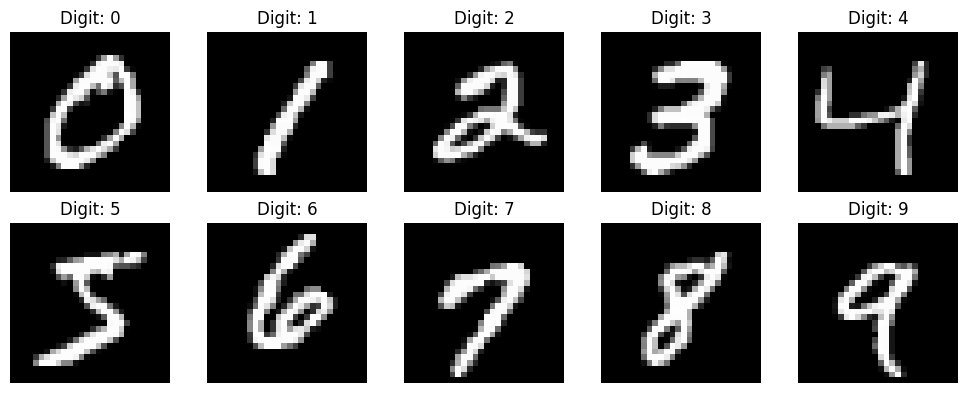

In [45]:
csv_file_path = "/content/drive/MyDrive/AI and Machine Learning/Week2/mnist_dataset.csv"
X_train, X_test, y_train, y_test = load_and_prepare_mnist(csv_file_path)

### **A Quick debugging Step:**

In [38]:
assert len(X_train) == len(y_train), f"Error: X and y have different lengths! X={len(X_train)}, y={len(y_train)}"
print("Move forward: Dimension of Feture Matrix X and label vector y matched.")

Move forward: Dimension of Feture Matrix X and label vector y matched.


## **Train the Model:**

In [39]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (48000, 784)
Test data shape: (12000, 784)


Iteration 0: Cost = 2.188632
Iteration 100: Cost = 0.607068
Iteration 200: Cost = 0.489423
Iteration 300: Cost = 0.440857
Iteration 400: Cost = 0.412804
Iteration 500: Cost = 0.393955
Iteration 600: Cost = 0.380147
Iteration 700: Cost = 0.369449
Iteration 800: Cost = 0.360832
Iteration 900: Cost = 0.353689
Iteration 999: Cost = 0.347690


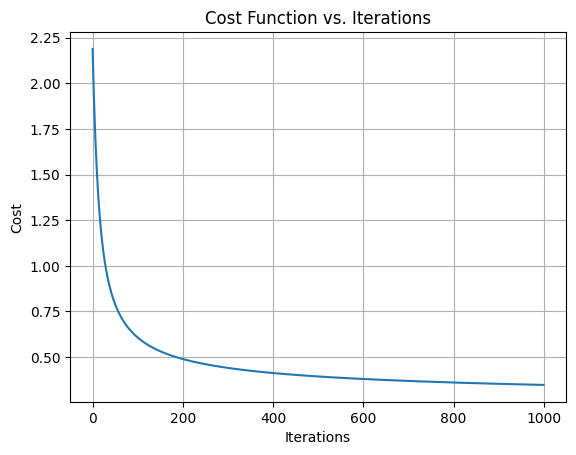

In [40]:
from sklearn.preprocessing import OneHotEncoder

if len(y_train.shape) == 1:
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))

d = X_train.shape[1]
c = y_train.shape[1]

W = np.random.randn(d, c) * 0.01
b = np.zeros(c)

alpha = 0.1
n_iter = 1000

W_opt, b_opt, cost_history = gradient_descent_softmax(X_train, y_train, W, b, alpha, n_iter, show_cost=True)

plt.plot(cost_history)
plt.title('Cost Function vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)
plt.show()


## **Evaluating the Model:**

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluate_classification(y_true, y_pred):
    """
    Evaluate classification performance using confusion matrix, precision, recall, and F1-score.

    Parameters:
    y_true (numpy.ndarray): True labels
    y_pred (numpy.ndarray): Predicted labels

    Returns:
    tuple: Confusion matrix, precision, recall, F1 score
    """
    cm = confusion_matrix(y_true, y_pred)

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return cm, precision, recall, f1



Confusion Matrix:
[[1126    0    5    2    3   12    9    2   13    3]
 [   0 1274    7   11    1    5    1    4   18    1]
 [   2   15 1028   16   19    3   26   25   34    6]
 [   8    5   33 1051    1   53    9    8   30   21]
 [   1    5    7    1 1096    0   10    4    4   48]
 [  22   14   12   43   11  926   14    7   41   14]
 [   6    2    9    1   11   15 1121    2   10    0]
 [   7   27   23    4   16    2    0 1183    7   30]
 [   9   28   13   34    9   33   13    6 1000   15]
 [   8    6   10   18   43    9    0   38   10 1052]]
Precision: 0.90
Recall: 0.90
F1-Score: 0.90


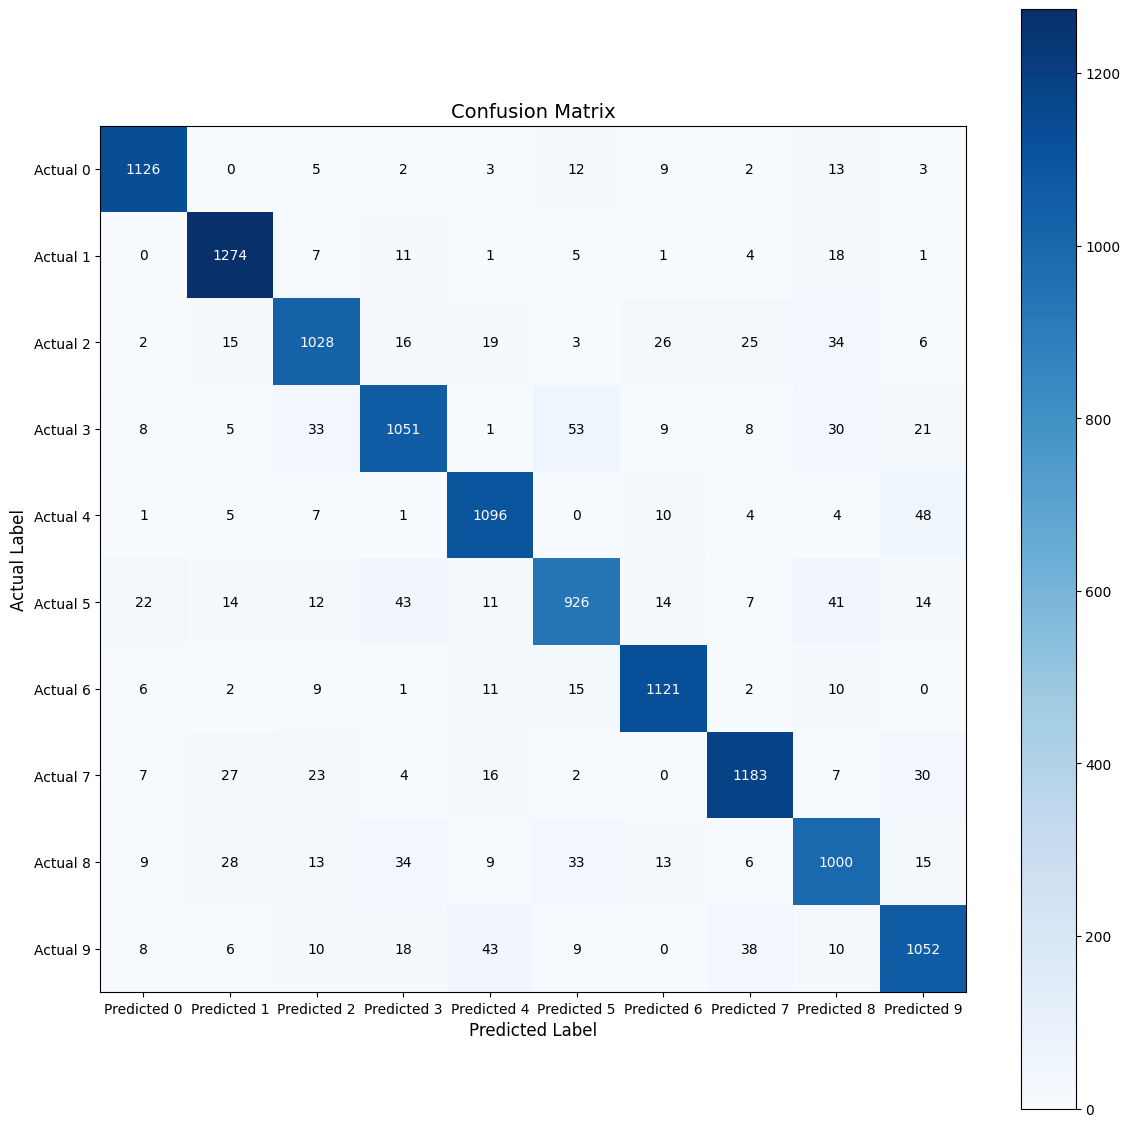

In [42]:
y_pred_test = predict_softmax(X_test, W_opt, b_opt)

y_test_labels = np.argmax(y_test, axis=1)

cm, precision, recall, f1 = evaluate_classification(y_test_labels, y_pred_test)

print("\nConfusion Matrix:")
print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(cm, cmap='Blues')

num_classes = cm.shape[0]
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels([f'Predicted {i}' for i in range(num_classes)])
ax.set_yticklabels([f'Actual {i}' for i in range(num_classes)])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > np.max(cm) / 2 else 'black')

ax.grid(False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

plt.tight_layout()
plt.colorbar(cax)
plt.show()


# Linear Seperability and Logistic Regression:

<ipython-input-43-6a5a1fca6a1b>:19: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', marker='x', label='Test')


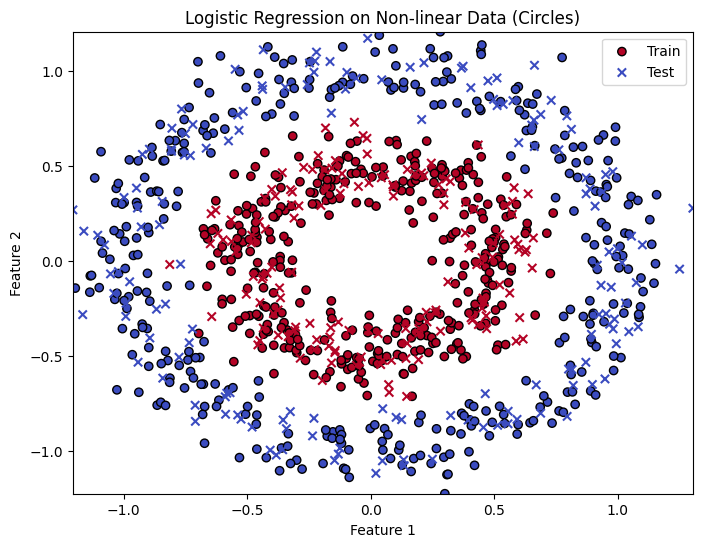

In [43]:
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))

plt.contourf(xx, yy, Z, levels=[0, 0.5], cmap='Blues', alpha=0.2)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', marker='x', label='Test')

plt.title("Logistic Regression on Non-linear Data (Circles)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

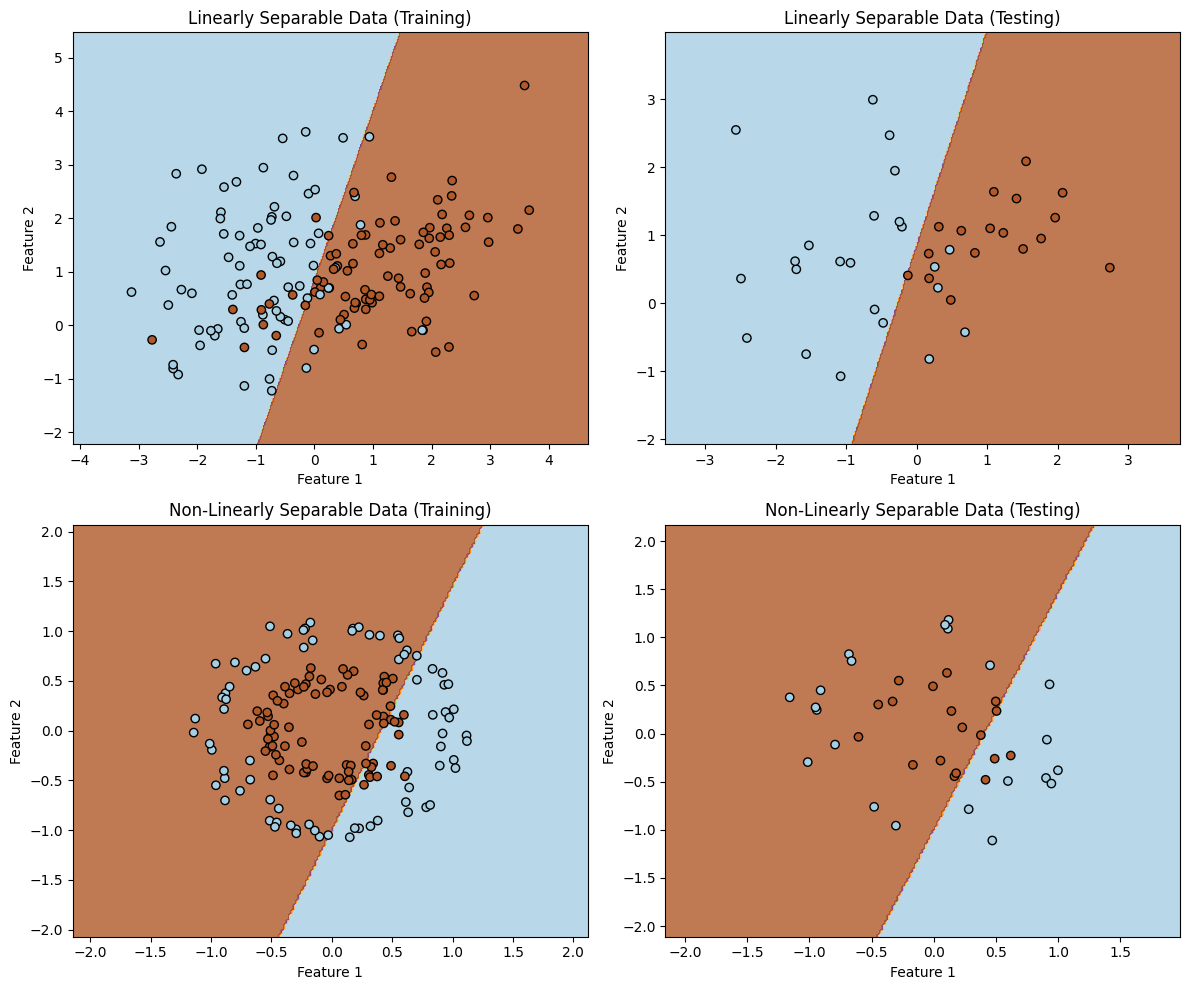

In [44]:
np.random.seed(42)

X_linear_separable, y_linear_separable = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear_separable, y_linear_separable, test_size=0.2, random_state=42)
logistic_model_linear_separable = LogisticRegression()
logistic_model_linear_separable.fit(X_train_linear, y_train_linear)

X_non_linear_separable, y_non_linear_separable = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)
X_train_non_linear, X_test_non_linear, y_train_non_linear, y_test_non_linear = train_test_split(X_non_linear_separable, y_non_linear_separable, test_size=0.2, random_state=42)
logistic_model_non_linear_separable = LogisticRegression()
logistic_model_non_linear_separable.fit(X_train_non_linear, y_train_non_linear)

def plot_decision_boundary(ax, model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plot_decision_boundary(axes[0, 0], logistic_model_linear_separable, X_train_linear, y_train_linear, "Linearly Separable Data (Training)")
plot_decision_boundary(axes[0, 1], logistic_model_linear_separable, X_test_linear, y_test_linear, "Linearly Separable Data (Testing)")
plot_decision_boundary(axes[1, 0], logistic_model_non_linear_separable, X_train_non_linear, y_train_non_linear, "Non-Linearly Separable Data (Training)")
plot_decision_boundary(axes[1, 1], logistic_model_non_linear_separable, X_test_non_linear, y_test_non_linear, "Non-Linearly Separable Data (Testing)")

plt.tight_layout()
plt.show()


##Questions:

1. Provide an interpretation of the output based on your understanding.
- For linearly separable data, the decision boundary can clearly separate the two classes. The diagrams show that most of the data points are correctly classified in both training and testing. This means that logistic regression performs well on data that follows a linear pattern.


2. Describe any challenges you faced while implementing the code above.
- For non-linearly separable data, the decision boundary cannot properly separate the two classes because it is still a straight line, while the data points are arranged in a circular pattern. Many points are misclassified, showing that logistic regression is not suitable for non-linear classification.